# Evaporation from ZAMG INCA data (NetCDF)
*A. Kokimova, November 2021, University of Graz*


What is done:

- load the data from ZAMG
- estimate potential evaporation
- plot and store results

Data source: ZAMG - https://data.hub.zamg.ac.at

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pyet
pyet.show_versions()

Python version: 3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]
Numpy version: 1.21.5
Scipy version: 1.7.3
Pandas version: 1.4.2
Matplotlib version: 3.5.1
Pyet version: 1.1.0b


## Loading daily data from ZAMG (INCA hourly NetCDF data)

In [2]:
#read data
xr_ds = xr.open_dataset("data//example_2//incal_hourly_20120501T0000_20120930T2300.nc", 
            engine="netcdf4")

In [3]:
# Resample and define input meteorological variables
tmean = xr_ds["T2M"].resample(time="1D").mean()
tmax = xr_ds["T2M"].resample(time="1D").max()
tmin = xr_ds["T2M"].resample(time="1D").min()
rh = xr_ds["RH2M"].resample(time="1D").mean()
rhmax = xr_ds["RH2M"].resample(time="1D").max()
rhmin = xr_ds["RH2M"].resample(time="1D").min()
wind = ((np.abs(xr_ds["VV"]) + xr_ds["UU"]) / 2).resample(time="1D").mean()
rs = xr_ds["GL"].resample(time="1D").mean() * 86400 / 1000000

In [4]:
# Define latitude and elevation
lat =  tmean.lat * np.pi / 180  
elevation = lat / lat * 350

## Calculate PET

In [5]:
# Estimate evaporation with nine different methods 
pe_penman = pyet.penman(tmean, wind, rs=rs, elevation=elevation, lat=lat, tmax=tmax, tmin=tmin, rh=rh)
pe_pt = pyet.priestley_taylor(tmean, rs=rs, elevation=elevation, lat=lat, tmax=tmax, tmin=tmin, rh=rh)
pe_makkink = pyet.makkink(tmean, rs, elevation=elevation)
pe_fao56 = pyet.pm_fao56(tmean, wind, rs=rs, elevation=elevation, lat=lat, tmax=tmax, tmin=tmin, rh=rh)
pe_hamon = pyet.hamon(tmean, lat=lat, method=1)
pe_oudin = pyet.oudin(tmean, lat=lat)
pe_haude = pyet.haude(tmax, rh)
pe_turc = pyet.turc(tmean, rs, rh)
pe_har = pyet.hargreaves(tmean, tmax, tmin, lat)

### Plot results

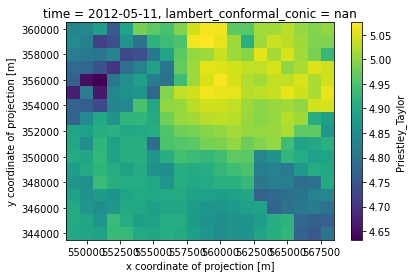

In [6]:
pe_pt[10,:,:].plot()

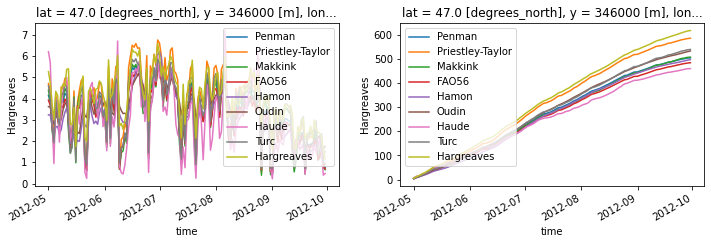

In [7]:
fig, axs = plt.subplots(ncols=2, figsize=(12,3))
pe_penman[:,2,2].plot(ax=axs[0], label="Penman")
pe_pt[:,2,2].plot(ax=axs[0], label="Priestley-Taylor")
pe_makkink[:,2,2].plot(ax=axs[0], label="Makkink")
pe_fao56[:,2,2].plot(ax=axs[0], label="FAO56")
pe_hamon[:,2,2].plot(ax=axs[0], label="Hamon")
pe_oudin[:,2,2].plot(ax=axs[0], label="Oudin")
pe_haude[:,2,2].plot(ax=axs[0], label="Haude")
pe_turc[:,2,2].plot(ax=axs[0], label="Turc")
pe_har[:,2,2].plot(ax=axs[0], label="Hargreaves")
axs[0].legend()

pe_penman[:,2,2].cumsum().plot(ax=axs[1], label="Penman")
pe_pt[:,2,2].cumsum().plot(ax=axs[1], label="Priestley-Taylor")
pe_makkink[:,2,2].cumsum().plot(ax=axs[1], label="Makkink")
pe_fao56[:,2,2].cumsum().plot(ax=axs[1], label="FAO56")
pe_hamon[:,2,2].cumsum().plot(ax=axs[1], label="Hamon")
pe_oudin[:,2,2].cumsum().plot(ax=axs[1], label="Oudin")
pe_haude[:,2,2].cumsum().plot(ax=axs[1], label="Haude")
pe_turc[:,2,2].cumsum().plot(ax=axs[1], label="Turc")
pe_har[:,2,2].cumsum().plot(ax=axs[1], label="Hargreaves")
axs[1].legend()

### Store results

In [8]:
#pe_pt.to_netcdf('../pe_pt_INCA.csv')